Installations

In [67]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [68]:
!pip install -q timm

In [69]:
!pip install --upgrade pymupdf
!pip install tabula-py

In [77]:
import fitz

Converting pdf to image for preprocessing

In [78]:
doc = fitz.open('Task.pdf')
print(doc.page_count)

230


In [79]:
page = doc.load_page(68)
pix = page.get_pixmap()
pix.save(f"page-{page.number}.png")

In [80]:
file_name = f"page-{page.number}.png"

Preprocessing of image

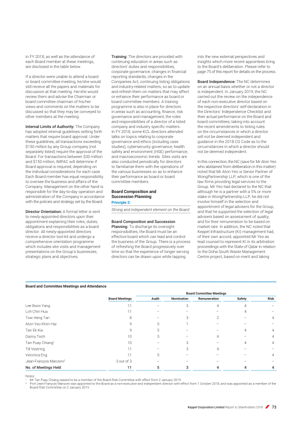

In [81]:
from huggingface_hub import hf_hub_download
from PIL import Image
image = Image.open(file_name).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [82]:
from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [11]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1130, 800])


In [12]:
from transformers import TableTransformerForObjectDetection
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint

In [13]:
import torch
with torch.no_grad():
  outputs = model(**encoding)

In [14]:
import matplotlib.pyplot as plt # colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125], [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
def plot_results(pil_img, scores, labels, boxes):
  plt.figure(figsize=(16,10))
  plt.imshow(pil_img)
  ax = plt.gca()
  colors = COLORS * 100
  for score, label, (xmin, ymin, xmax, ymax),c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
    text = f'{model.config.id2label[label]}: {score:0.2f}'
    ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [15]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

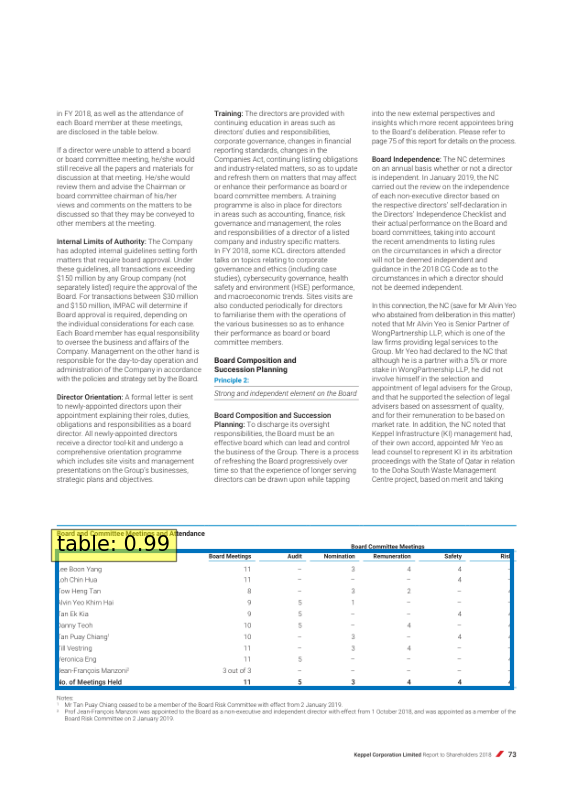

In [17]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
!pip install camelot-py[cv]

Extracting table contents

In [50]:
boxes = results['boxes']
xmin, ymin, xmax, ymax = boxes[0].tolist()

In [ ]:
# page 68 in mumypdf is equvalent to page 69 in tabula

In [125]:
from tabulate import tabulate
import tabula
from tabula.io import read_pdf

In [113]:
top = ymin
left = xmin
bottom = ymax
right = xmax

# Specify the area for table extraction
area = [top, left, bottom, right]

In [127]:
tabula.convert_into('Task.pdf', 'converted.csv', output_format='csv', pages=69, area=area)

In [130]:
import pandas as pd

df = pd.read_csv('converted.csv')

# Display the extracted table
print(df)

                Unnamed: 0 Board Meetings Audit Nomination Remuneration  \
0            Lee Boon Yang             11     –          3            4   
1             Loh Chin Hua             11     –          –            –   
2             Tow Heng Tan              8     –          3            2   
3      Alvin Yeo Khirn Hai              9     5          1            –   
4               Tan Ek Kia              9     5          –            –   
5               Danny Teoh             10     5          –            4   
6         Tan Puay Chiang1             10     –          3            –   
7            Till Vestring             11     –          3            4   
8             Veronica Eng             11     5          –            –   
9   Jean-François Manzoni2     3 out of 3     –          –            –   
10    No. of Meetings Held             11     5          3            4   

   Safety Risk  
0       4    –  
1       4    –  
2       –    4  
3       –    –  
4       4    4